In [2]:
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
sys.path.insert(0, '../../models')
sys.path.insert(0, '../../utils/')
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from unet_jvanvugt.unet import UNet as unet

from pytorch_summary.torchsummary import summary

def imshow_pair(im, gdt):
    f, ax = plt.subplots(1, 2, figsize=(12,6))
    np_im = np.asarray(im)
    np_gdt = np.asarray(gdt)
    if len(np_im.shape) == 2:
        ax[0].imshow(np_im, cmap='gray'),  ax[0].axis('off')
    else:
        ax[0].imshow(np_im),  ax[0].axis('off')
    if len(np_gdt.shape) == 2:
        ax[1].imshow(np.asarray(gdt), cmap = 'gray'), ax[1].axis('off')
    else:
        ax[1].imshow(np.asarray(gdt)), ax[1].axis('off')
    plt.tight_layout()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Models origin
In this project we re-use a public implementation of U-Net, namely from [jvanvugt](https://github.com/jvanvugt/pytorch-unet). Please visit the original repository for a more detailed documentation.

# Model Usage

**Note**: If you are using a computing server with several GPUs and you want to use a specific one, you should run `nvidia-smi`, select the index of the one you want, and add to your code something like:
```
import os
os.environ[CUDA_VISIBLE_DEVICES]=0 # or whatever gpu you want
```
If you are launching a python script (say, `train.py`), and you want to use a particular gpu, you would run in the terminal:
```
CUDA_VISIBLE_DEVICES=0 python train.py
```

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
# default parameters build the unet from the original paper
model = unet(n_classes=1, in_channels=3, padding=True, up_mode='upsample').to(device)

In [5]:
channels, H, W = 3, 512, 512
summary(model, input_size=(channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
     UNetConvBlock-5         [-1, 64, 512, 512]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
    UNetConvBlock-10        [-1, 128, 256, 256]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

We can use less depth levels and a reduced number of filters to **drastically** decrease complexity

In [6]:
model = unet(n_classes=1, in_channels=3, depth=3, wf=3, padding=True, up_mode='upsample').to(device)
summary(model, input_size=(channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]             224
              ReLU-2          [-1, 8, 512, 512]               0
            Conv2d-3          [-1, 8, 512, 512]             584
              ReLU-4          [-1, 8, 512, 512]               0
     UNetConvBlock-5          [-1, 8, 512, 512]               0
            Conv2d-6         [-1, 16, 256, 256]           1,168
              ReLU-7         [-1, 16, 256, 256]               0
            Conv2d-8         [-1, 16, 256, 256]           2,320
              ReLU-9         [-1, 16, 256, 256]               0
    UNetConvBlock-10         [-1, 16, 256, 256]               0
           Conv2d-11         [-1, 32, 128, 128]           4,640
             ReLU-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 32, 128, 128]           9,248
             ReLU-14         [-1, 32, 1

# A model in action
Let us load a batch of our images and pass it through a Unet

In [9]:
from get_loaders import get_train_val_loaders
path_data = '../../data/DRIVE/'

In [10]:
train_loader, val_loader = get_train_val_loaders(path_data, train_proportion=.8, batch_size=4)

In [11]:
ims, labels = next(iter(train_loader))

In [12]:
model = unet(n_classes=2, in_channels=3, depth=3, wf=3, batch_norm=True, 
              padding=True, up_mode='upsample').to(device)

In [13]:
logits = model(ims.to(device))

In [14]:
ims.shape, logits.shape, labels.shape

(torch.Size([4, 3, 512, 512]),
 torch.Size([4, 2, 512, 512]),
 torch.Size([4, 512, 512]))

# Pytorch Loss Functions
Since we are dealing with binary classification, typically a Unet should return only one output channel (`n_classes=1` in the definition of the above model). Then, we would use `torch.nn.BCEWithLogitsLoss()` as our loss function (BCE stands for Binary Cross-Entropy).

However, the targets from our dataloader are returned in a format to be used in multi-class classification problems, where `n_classes>=2`. For such problems, we would use `torch.nn.CrossEntropyLoss()`. 

There are two options now:
* Either we want to use `BCEWithLogitsLoss()`, in which case we will need to instantiate a model with `n_classes=1` and manipulate a bit our labels (casting to `float` and adding a fake channel), 
* Or we want to use `CrossEntropyLoss()`, in which case we will need to instantiate a model with `n_classes=2`, and we won't need to manipulate the labels.  

In [15]:
# case 1
criterion = torch.nn.BCEWithLogitsLoss()

In [16]:
model = unet(n_classes=1, in_channels=3, depth=3, wf=3, batch_norm=True, 
              padding=True, up_mode='upsample').to(device)

In [17]:
ims, labels = next(iter(train_loader))

In [18]:
logits = model(ims.to(device))

In [19]:
logits.shape, labels.shape, labels.dtype

(torch.Size([4, 1, 512, 512]), torch.Size([4, 512, 512]), torch.int64)

In [20]:
labels = labels.unsqueeze(dim=1).float()
labels.shape, labels.dtype

(torch.Size([4, 1, 512, 512]), torch.float32)

In [21]:
criterion(logits, labels)

tensor(0.7984, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [22]:
# case 2
criterion = torch.nn.CrossEntropyLoss()

In [23]:
model = unet(n_classes=2, in_channels=3, depth=3, wf=3, batch_norm=True, 
              padding=True, up_mode='upsample').to(device)

In [24]:
ims, labels = next(iter(train_loader))

In [25]:
logits = model(ims.to(device))

In [26]:
logits.shape, labels.shape, labels.dtype

(torch.Size([4, 2, 512, 512]), torch.Size([4, 512, 512]), torch.int64)

In [27]:
criterion(logits, labels)

tensor(0.7342, grad_fn=<NllLoss2DBackward>)

The difference between each kind of loss function is that `BCEWithLogitsLoss()` internally passes the logits through a `sigmoid` function, whereas `CrossEntropyLoss()` passes them through a `softmax()`. This is much better explained [here](https://discuss.pytorch.org/t/why-is-beclosswithlogits-compute-different-value-from-crossentropyloss/40818/2). 

For a mathematical explanation of why and how pytorch handles binary/cross-entropy losses like that, I really recommend to have a look at [this link](https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html).

# Training a model

For the `BCEWithLogitsLoss()` loss we would proceed as follows:

In [28]:
from tqdm import tqdm, trange
from tqdm import tqdm_notebook as tqdm

In [29]:
train_loader, val_loader = get_train_val_loaders(path_data, train_proportion=.8, batch_size=1)


n_classes = 1
model = unet(n_classes=n_classes, in_channels=3, depth=3, wf=3, batch_norm=True, 
              padding=True, up_mode='upsample').to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 10

In [30]:
for epoch in range(epochs):
    print('EPOCH: {:d}/{:d}'.format(epoch+1, epochs))
    # Run a training epoch
    model.train()
    with trange(len(train_loader)) as t:
        n_elems, running_loss = 0, 0
        for i_batch, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device) # [N, C, H, W]
            labels = labels.unsqueeze(dim=1).float().to(device) # [N, 1, H, W] float type   
            logits = model(inputs)  # [N, 1, H, W]

            loss = criterion(logits, labels)            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute running loss
            running_loss += loss.item() * inputs.size(0)
            n_elems += inputs.size(0)
            run_loss = running_loss / n_elems
            t.set_postfix(tr_loss="{:.4f}".format(float(run_loss)))
            t.update()            

    # Run a validation epoch
    model.eval()
    with torch.no_grad(): # no need of gradients as we won't backpropagate, saves memory and it is quicker
        with trange(len(val_loader)) as t:
            n_elems, running_loss = 0, 0
            for i_batch, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device) # [N, C, H, W]
                labels = labels.unsqueeze(dim=1).float().to(device) # [N, 1, H, W] float type   
                logits = model(inputs)  # [N, 1, H, W]

                loss = criterion(logits, labels)    
                
#                 We don't need these in validation:
#                 optimizer.zero_grad()  
#                 loss.backward()
#                 optimizer.step()

                # Compute running loss
                running_loss += loss.item() * inputs.size(0)
                n_elems += inputs.size(0)
                run_loss = running_loss / n_elems
                t.set_postfix(vl_loss="{:.4f}".format(float(run_loss)))
                t.update()            

    if epoch == 0:
            break

  0%|          | 0/16 [00:00<?, ?it/s]

EPOCH: 1/10


100%|██████████| 4/4 [00:01<00:00,  2.16it/s, vl_loss=0.7498]


For the `CrossEntropyLoss()` loss we would proceed as follows:

In [31]:
n_classes = 2
model = unet(n_classes=n_classes, in_channels=3, depth=3, wf=3, batch_norm=True, 
              padding=True, up_mode='upsample').to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 10

In [32]:
for epoch in range(epochs):
    print('EPOCH: {:d}/{:d}'.format(epoch+1, epochs))
    # Run a training epoch
    model.train()
    with trange(len(train_loader)) as t:
        n_elems, running_loss = 0, 0
        for i_batch, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device) # [N, C, H, W]
            labels = labels.to(device) # [N, H, W] with class indices (0, 1), integer type    
            logits = model(inputs)  # [N, 2, H, W]

            loss = criterion(logits, labels)            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute running loss
            running_loss += loss.item() * inputs.size(0)
            n_elems += inputs.size(0)
            run_loss = running_loss / n_elems
            t.set_postfix(tr_loss="{:.4f}".format(float(run_loss)))
            t.update()            

    # Run a validation epoch
    model.eval()
    with torch.no_grad(): # no need of gradients as we won't backpropagate, saves memory and it is quicker
        with trange(len(val_loader)) as t:
            n_elems, running_loss = 0, 0
            for i_batch, (inputs, labels) in enumerate(val_loader):
                inputs = inputs.to(device) # [N, C, H, W]
                labels = labels.to(device) # [N, H, W] with class indices (0, 1), integer type    
                logits = model(inputs)  # [N, 2, H, W]

                loss = criterion(logits, labels)            

#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()

                # Compute running loss
                running_loss += loss.item() * inputs.size(0)
                n_elems += inputs.size(0)
                run_loss = running_loss / n_elems
                t.set_postfix(vl_loss="{:.4f}".format(float(run_loss)))
                t.update()            

    if epoch == 0:
            break

  0%|          | 0/16 [00:00<?, ?it/s]

EPOCH: 1/10


100%|██████████| 4/4 [00:01<00:00,  2.37it/s, vl_loss=0.4738]


## Refactoring for a cleaner code
Let us encapsulate the training loop for an epoch into a single function that we can call. Note that this function will automatically infer if we are in training mode from the presence or absence of an optimizer when we call it. Also, we are now returning the loss, the logits, and the labels, which we will use later for evaluating results.

In [45]:
def run_one_epoch(loader, model, criterion, optimizer=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train = optimizer is not None # if we are in training mode there will be an optimizer and train=True here

    if train:
        model.train()
    else:
        model.eval()
    logits_all, labels_all = [], []
    with trange(len(loader)) as t:
        n_elems, running_loss = 0, 0
        for i_batch, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device) 
            labels = labels.unsqueeze(dim=1).float().to(device) # for use with BCEWithLogitsLoss()
            logits = model(inputs)
            
            logits_all.extend(logits)
            labels_all.extend(labels)
            
            loss = criterion(logits, labels)            
            if train: # only in training mode
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Compute running loss
            running_loss += loss.item() * inputs.size(0)
            n_elems += inputs.size(0)
            run_loss = running_loss / n_elems
            if train:
                t.set_postfix(tr_loss="{:.4f}".format(float(run_loss)))
            else:
                t.set_postfix(vl_loss="{:.4f}".format(float(run_loss)))
            t.update()            
    return logits_all, labels_all, run_loss

Let us use our new function with the `BCEWithLogitsLoss()` version:

In [34]:
train_loader, val_loader = get_train_val_loaders(path_data, train_proportion=.8, batch_size=4)

n_classes = 1
model = unet(n_classes=n_classes, in_channels=3, depth=3, wf=3, batch_norm=True, 
              padding=True, up_mode='upsample').to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

epochs = 1

In [35]:
for epoch in range(epochs):
    print('EPOCH: {:d}/{:d}'.format(epoch+1, epochs))
    # train one epoch
    train_logits, train_labels, train_losses = run_one_epoch(train_loader, model, criterion, optimizer)
    # validate one epoch, note no optimizer is passed
    with torch.no_grad():
        val_logits, val_labels, val_losses = run_one_epoch(val_loader, model, criterion)

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 1/1


100%|██████████| 1/1 [00:02<00:00,  2.25s/it, tr_loss=0.8241]


## Evaluation during training
After each epoch, you want to know the current performance of your model. If the model is starting to get worse on the validation data you are experiencing overfitting.

In order to evaluate performance, we look at the logits and labels. Since we are using `BCEWithLogitsLoss()`, this means that in order to obtain predictions we need to pass them through a sigmoid. Have a look at [this link](https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html) if you don't understand the previous sentence.

Lets have a look at what we got from the previous cell. `val_labels` is a `list` that contains as many tensors as elements in the validation set. The same goes for `val_logits`. What is the shape of each of these tensors?

In [36]:
for i in range(len(val_logits)):
    print(val_logits[i].shape, val_labels[i].shape)

torch.Size([1, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 512, 512]) torch.Size([1, 512, 512])
torch.Size([1, 512, 512]) torch.Size([1, 512, 512])


These are `n_channels x height x width` tensors, being `n_channels=1`. We therefore want to analyze `val_logits[i][0]`. Note that if this object lived in the gpu we need to move it to the cpu first. We also need to call `detach()` on these objects, since we don't need the gradients. Finally, we prefer to deal with this being a `numpy` array, as we now how to perform evaluation with these arrays better.

Note that we are also passing the logits through a sigmoid in the following cell:

In [37]:
prediction = torch.sigmoid(val_logits[0][0]).detach().cpu().numpy()
target = val_labels[0][0].cpu().numpy()

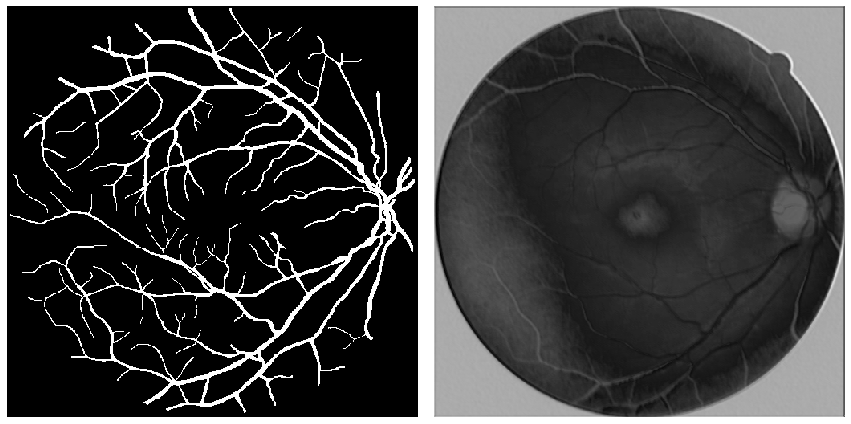

In [38]:
imshow_pair(target, prediction)

As you see, predictions are quite bad, but this is because we only trained for one epoch. They will hopefully get better! Now we need to compute performance, and this you want to do using the techniques studied in the previous notebook `2_evaluation.ipynb`.

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score

roc_auc_score(target.ravel(), prediction.ravel())

0.3908545741639605

I hope you rememember that a proper evaluation is based on accumulating the predictions and labels across all validation images before computing the auc. In our case, this would be done as follows:

In [40]:
all_preds = []
all_targets = []

for i in range(len(val_logits)):
    prediction = torch.sigmoid(val_logits[i][0]).detach().cpu().numpy()
    target = val_labels[i][0].cpu().numpy()
    
    all_preds.append(prediction.ravel())
    all_targets.append(target.ravel())
    
all_preds_np = np.hstack(all_preds).ravel()
all_targets_np = np.hstack(all_targets).ravel()

So this would be the overall AUC of our model for the entire validation set at this point of the training:

In [41]:
roc_auc_score(all_targets_np, all_preds_np)

0.3897666195361041

Let us encapsulate our evaluation code into a function:

In [42]:
def evaluate(logits, labels):
    all_preds = []
    all_targets = []

    for i in range(len(logits)):
        prediction = torch.sigmoid(logits[i][0]).detach().cpu().numpy()
        target = labels[i][0].cpu().numpy()

        all_preds.append(prediction.ravel())
        all_targets.append(target.ravel())

    all_preds_np = np.hstack(all_preds).ravel()
    all_targets_np = np.hstack(all_targets).ravel()
    
    return roc_auc_score(all_targets_np, all_preds_np)

In [43]:
evaluate(val_logits, val_labels)

0.3897666195361041

Let us try to run another few more epochs and see how our performance increases:

In [44]:
epochs = 20

tr_losses, tr_aucs  = [], []
vl_losses, vl_aucs  = [], []

for epoch in range(epochs):
    print('EPOCH: {:d}/{:d}'.format(epoch+1, epochs))
    # train one epoch
    train_logits, train_labels, train_loss = run_one_epoch(train_loader, model, criterion, optimizer)
    train_auc = evaluate(train_logits, train_labels)
    # validate one epoch, note no optimizer is passed
    with torch.no_grad():
        val_logits, val_labels, val_loss = run_one_epoch(val_loader, model, criterion)
    
    val_auc = evaluate(val_logits, val_labels)
    
    # store performance for this epoch
    tr_losses.append(train_loss)
    tr_aucs.append(train_auc)
    
    vl_losses.append(val_loss)
    vl_aucs.append(val_auc)

  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 1/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 2/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 3/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 4/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 5/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 6/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 7/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 8/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 9/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 10/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 11/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 12/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 13/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 14/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 15/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 16/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 17/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 18/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 19/20


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 20/20


100%|██████████| 1/1 [00:02<00:00,  2.36s/it, tr_loss=0.5133]


In [46]:
evaluate(val_logits, val_labels)

0.9456266329114934

Looks good! Let us have a visual look:

In [47]:
prediction = torch.sigmoid(val_logits[0][0]).detach().cpu().numpy()
target = val_labels[0][0].cpu().numpy()

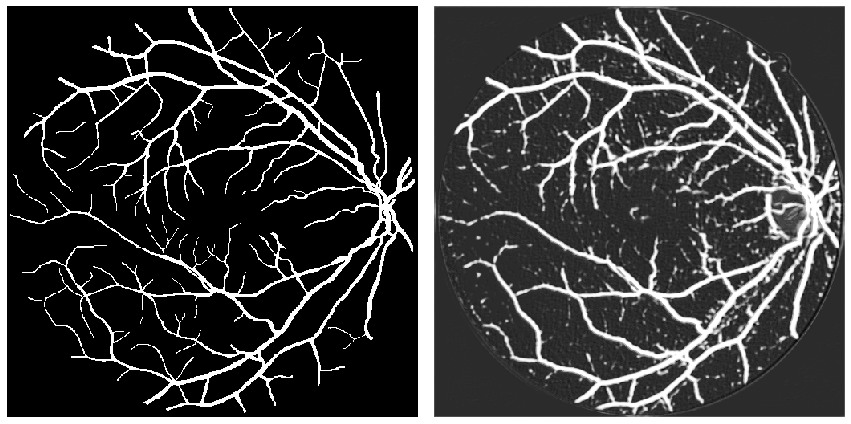

In [48]:
imshow_pair(target, prediction)

## Model checkpointing
Above, we also saved the performance per epoch, so we can now for instance have a look at its evolution. We can look at the loss per epoch (both in training and validation), or at the AUC per epoch:

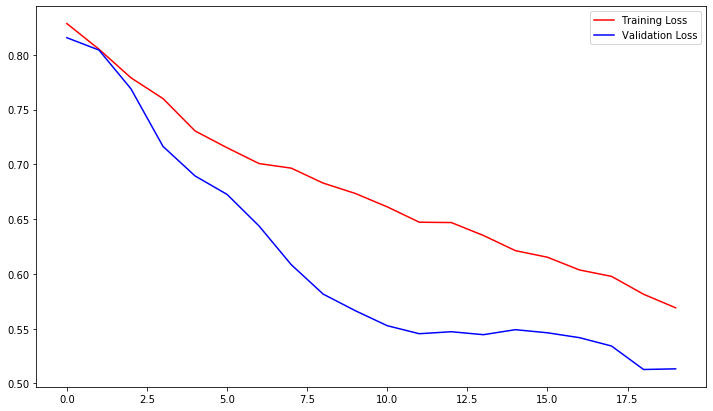

In [49]:
plt.figure(figsize=(12,7))
x = np.arange(len(tr_losses))
plt.plot(x, tr_losses, '-r', label='Training Loss')
plt.plot(x, vl_losses, '-b', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

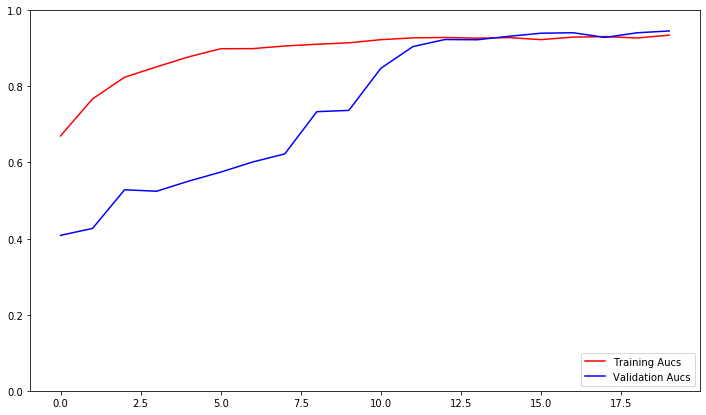

In [50]:
plt.figure(figsize=(12,7))
x = np.arange(len(tr_losses))
plt.plot(x, tr_aucs, '-r', label='Training Aucs')
plt.plot(x, vl_aucs, '-b', label='Validation Aucs')
plt.legend(loc='lower right')
plt.ylim([0,1])
plt.show()

We see that there is still quite a bit of room for improvement, and we may consider keeping on trainnig. However, it must be noted that, as training proceeds, at some point performance in the validation set will start to degrade, it will get worse. This means that we are starting to overfit, and the way to go with this is something called **early stopping**. This means that when you start to see performance stagnating, you want to stop training. Typically, we implement some kind of criteriium by which, if we do not see any performance improvement in `N` epochs, we decide to stop. That `N` is called **patience**.

Related to this, we also want to **checkpoint** our models. This means that we want to keep track of our performance in the validation set, and save the best model we have seen up to that moment. 

This is a simple function that will save a model to a directory specified in the variable `path`. It will optionally save training statistics (the track of losses and AUCs), if provided. Note that the directory will be created if it does not exist yet. Also, we are saving the optimizer state in case we want to resume training were we left it.

In [51]:
def save_model(path, model, optimizer, stats= None):
    os.makedirs(path, exist_ok=True)
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'stats':stats
            }, osp.join(path, 'checkpoint.pth'))

Below we implement both early stopping and model checkpointing:

In [53]:
path_checkpoint = '../../experiments/initial_experiment/'

epochs = 20 # let us train for 20 more epochs

patience = 10 # if performance does not increase during 10 epochs, we will stop training
counter_since_checkpoint = 0

best_val_auc = 0
best_val_loss = np.inf 

for epoch in range(epochs):
    print('\n EPOCH: {:d}/{:d}'.format(epoch+1, epochs))
    # train one epoch
    train_logits, train_labels, train_loss = run_one_epoch(train_loader, model, criterion, optimizer)
    train_auc = evaluate(train_logits, train_labels)
    # validate one epoch, note no optimizer is passed
    with torch.no_grad():
        val_logits, val_labels, val_loss = run_one_epoch(val_loader, model, criterion)
    
    val_auc = evaluate(val_logits, val_labels)
    
    # store performance for this epoch
    tr_losses.append(train_loss)
    tr_aucs.append(train_auc)
    
    vl_losses.append(val_loss)
    vl_aucs.append(val_auc)
    
    # check if performance was better than anyone before and checkpoint if so
    if val_auc > best_val_auc:
        print('\n Best AUC attained, checkpointing. {:.4f} > {:.4f}'.format(best_val_auc, val_auc))
        best_val_auc = val_auc
        save_model(path_checkpoint, model, optimizer)
        counter_since_checkpoint = 0 # reset patience
    else:
        counter_since_checkpoint += 1
    
    # early stopping if no improvement happend for `patience` epochs
    if counter_since_checkpoint ==patience:
        print('\n Early stopping the training')
        break

  0%|          | 0/4 [00:00<?, ?it/s]


 EPOCH: 1/20


  0%|          | 0/4 [00:00<?, ?it/s]


 Best AUC attained, checkpointing. 0.0000 > 0.9508

 EPOCH: 2/20


  0%|          | 0/4 [00:00<?, ?it/s]


 EPOCH: 3/20


  0%|          | 0/4 [00:00<?, ?it/s]


 Best AUC attained, checkpointing. 0.9508 > 0.9541

 EPOCH: 4/20


  0%|          | 0/4 [00:00<?, ?it/s]


 EPOCH: 5/20


  0%|          | 0/4 [00:00<?, ?it/s]


 EPOCH: 6/20


  0%|          | 0/4 [00:00<?, ?it/s]


 EPOCH: 7/20


  0%|          | 0/4 [00:00<?, ?it/s]


 EPOCH: 8/20


  0%|          | 0/4 [00:00<?, ?it/s]


 EPOCH: 9/20


  0%|          | 0/4 [00:00<?, ?it/s]


 EPOCH: 10/20


  0%|          | 0/4 [00:00<?, ?it/s]


 EPOCH: 11/20


  0%|          | 0/4 [00:00<?, ?it/s]


 EPOCH: 12/20


  0%|          | 0/4 [00:00<?, ?it/s]


 EPOCH: 13/20


100%|██████████| 1/1 [00:02<00:00,  2.71s/it, VAL_loss=0.4144]



 Early stopping the training


Let us look again at performance evolution graphically:

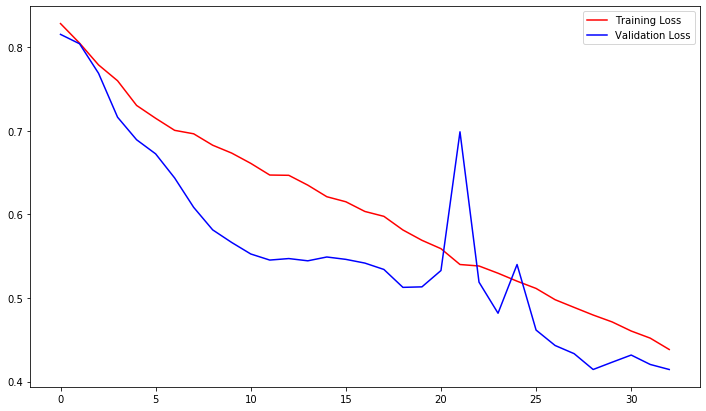

In [54]:
plt.figure(figsize=(12,7))
x = np.arange(len(tr_losses))
plt.plot(x, tr_losses, '-r', label='Training Loss')
plt.plot(x, vl_losses, '-b', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

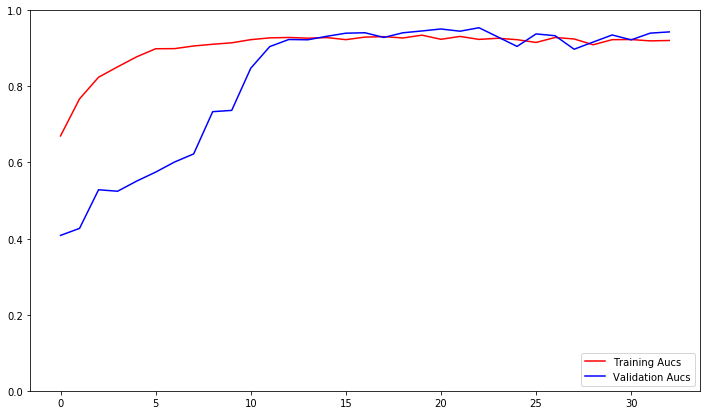

In [55]:
plt.figure(figsize=(12,7))
x = np.arange(len(tr_losses))
plt.plot(x, tr_aucs, '-r', label='Training Aucs')
plt.plot(x, vl_aucs, '-b', label='Validation Aucs')
plt.legend(loc='lower right')
plt.ylim([0,1])
plt.show()

## Final Homework
You now have almost all the tools to finish your project (have a look to the next notebook to finish). What you need to do now is to put everything together. For that, you need to implement the training loop, but in `python` files, much in the way the Stanford project you saw. For example, you want to put all the functions you use for evaluating performance (the `evaluate` function above, the `ewma` function below, etc.) in a separate folder called `evaluation`, and import from there what you need. You could also decide to move checkpointing functionalities to the `utils` folder and import from there; the logic is up to you, be reasonable.

In general, your goal is to create a `python` script called `train.py` that you can call from the command line, exposing some relevant hyperparameters. For instance, you could expose the depth and number of filters in the `unet` definition, and also the learning rate and the batch size. You will also probably want to expose the path were to save your checkpoints, so that you can vary it with everycall

```
python train.py --depth 3 --wf 3 --lr 0.001 --batch_size 8 --experiment_path experiment_depth3_wf_3
```

You will then need to run a full hyperparameter search (we can discuss over which hyperparameters when your code is working) in order to find an optimal model to use in test time.

## Remark
You may notice that at times this measures are a bit noisy. As you explore the model space, you may be quite unlucky at a given epoch and see a peak of bad performance, like the validation auc around epoch 8 in the above plot. It may be useful to smooth these before deciding to checkpoint. You could use a function like the one below:

In [56]:
def ewma(data, window=5):
    # exponetially-weighted moving averages
    data = np.array(data)
    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

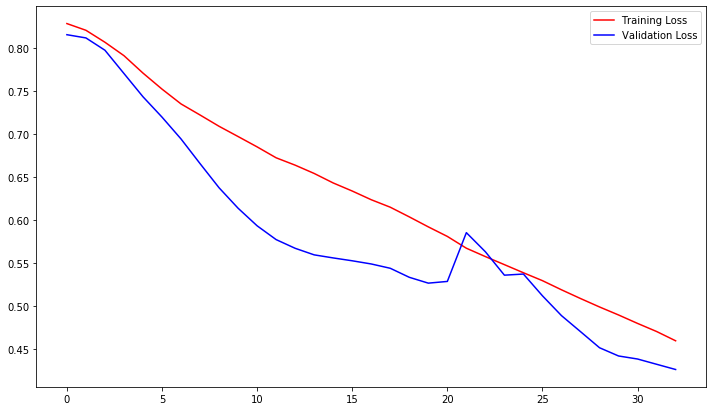

In [58]:
smooth_tr_losses = ewma(tr_losses)
smooth_vl_losses = ewma(vl_losses)

plt.figure(figsize=(12,7))
x = np.arange(len(tr_losses))
plt.plot(x, smooth_tr_losses, '-r', label='Training Loss')
plt.plot(x, smooth_vl_losses, '-b', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

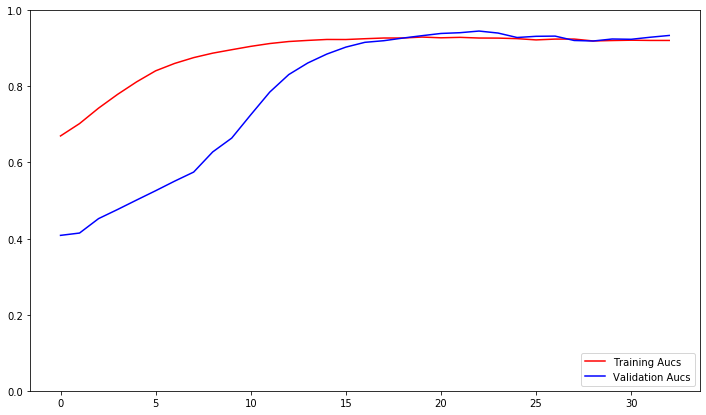

In [57]:
smooth_tr_aucs = ewma(tr_aucs)
smooth_vl_aucs = ewma(vl_aucs)

plt.figure(figsize=(12,7))
x = np.arange(len(tr_losses))
plt.plot(x, smooth_tr_aucs, '-r', label='Training Aucs')
plt.plot(x, smooth_vl_aucs, '-b', label='Validation Aucs')
plt.legend(loc='lower right')
plt.ylim([0,1])
plt.show()